<header style="padding:10px;background:#f9f9f9;border-top:3px solid #00b2b1"><img id="Teradata-logo" src="https://www.teradata.com/Teradata/Images/Rebrand/Teradata_logo-two_color.png" alt="Teradata" width="220" align="right" />
 
## TF-IDF Workflow in Python
</header>

**Notes**
* Teradata Python Package User Guide: https://docs.teradata.com/r/1YKutX2ODdO9ppo_fnguTA/root
* Teradataml function reference: https://docs.teradata.com/r/xLnbN80h9C6037gi3ildag/root
* NGramSplitter Function Reference: https://docs.teradata.com/r/aKnWloeEx3pmus0aivWOaw/0uzj9gM6ureUUJTXhxvmSQ

**Steps**
1. Replace any hosts, schemas, usernames, etc.
2. Connect to existing data set containing fake product comments.
3. Use NGramSplitter SQL to create a table of grams of n-size.
4. Express SQL to calculate TF-IDF and store the output in a table.
5. Retrieve the data as a local dataframe.
6. Basic visualization to show top 30 important terms.

In [1]:
import json
import getpass
import warnings
import os
from datetime import datetime, timedelta

import pandas as pd
import numpy as np

from teradataml.dataframe.dataframe import DataFrame
from teradataml.analytics.sqle import NGramSplitter
from teradataml.dataframe.dataframe import in_schema
from teradataml.context.context import create_context, remove_context, get_context
from teradataml.dataframe.copy_to import copy_to_sql
from teradataml.dataframe.fastload import fastload
from teradataml.options.display import display

from teradatasqlalchemy.types import *

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set()
warnings.filterwarnings('ignore')


### Connect to Vantage ###
Can use the named connection using the tdconnect library as part of the Vantage Module for Jupyter ***OR*** use create_context method in teradataml.

In [2]:
# Connect to Vantage
eng = create_context(host = 'host.docker.internal', username='demo_user', password = getpass.getpass())

 ········


In [3]:
# Connect using teradataml methods
# user = 'ID'
# host = 'HOST'
# login_mechanism = 'LDAP'

# eng = create_context(host = host, username = user, password = getpass.getpass(prompt = 'Password:'), logmech = login_mechanism)

# print(eng)

### Access data in Vantage ###
For this demo, data is already resident in Vantage.  Create a reference to the table, and sample the contents.  Data could just as easily reside in Object Storage, another RDBMS, or another Vantage system.

In [4]:
tdf_reviews = DataFrame('"TRNG_RETAILDSE"."WEB_COMMENT"')
tdf_reviews.head(5)

comment_id,customer_id,comment_text,comment_summary
2.000,1077.000,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",Some major design flaws
4.000,847.000,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,Flattering shirt
3.000,1049.000,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",My favorite buy!
1.000,1080.000,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",None
0.000,767.000,Absolutely wonderful - silky and sexy and comfortable,None


### Use the NGram Splitter SQL Function ###
This function will split the corpus of documents into "terms" (grams) of selected size.  Specifically, this example will create a table called "tbl_grams" that is the result of splitting each "document" (review) into two-word chunks (grams).  Each row in this table includes;
1. The two-word chunk (ngram).
2. The source review id (row_id).
3. Chunk length (n).
4. The count of this chunk in the review (frequency).
5. The count of this chunk in all the reviews (totalcnt).

The splitting algorithm can be controlled with delimeters, punctuation indicators, etc.

In [5]:

qry = 'DROP TABLE tbl_grams;'

try:
    eng.execute(qry)
except Exception as e:
    if str(e.args).find('3807') >= 1:
        pass
    else:
        raise

#how many grams should we split the docs into?
grams = 2

#Create ngram table
qry = f'''
CREATE TABLE tbl_grams AS (
    SELECT * FROM NGramSplitter ( 
        ON ( SELECT * FROM "TRNG_RETAILDSE"."WEB_COMMENT" )   
        USING 
            TextColumn('comment_text') 
            Accumulate('comment_id') 
            Grams('{grams}') 
            OverLapping('TRUE') 
            ConvertToLowerCase('TRUE') 
            Delimiter(' ') 
            Punctuation('[`~#^&*()-]') 
            OutputTotalGramCount('TRUE') 
            NGramColName('ngram') 
            GramLengthColName('n') 
            FrequencyColName('frequency') 
            TotalCountColName('totalcnt') 
    ) as ngram_out
    )
WITH DATA
PRIMARY INDEX (comment_id);
'''

eng.execute(qry)

tdf_grams = DataFrame('tbl_grams')

tdf_grams.to_pandas(num_rows = 5).head()

,ngram,n,frequency,totalcnt
comment_id,,,,
8315,waist is,2,1,82
14062,t shirts,2,1,27
13059,the body,2,1,91
15657,33 25,2,1,77
1695,nice as,2,1,11


### Create the TF-IDF Table ###
TF-IDF or ***Term Frequency-Inverse Document Frequency*** is an indicator of a term's *importance* in a specific document based on the entire corpus of documents.  This value is calculated by taking the Product of:
* Term Frequency = (Number of Terms in the Document)/(Number of Terms in the Corpus)
* Inverse Document Frequency = Natural Log((Total Number of Documents)/(Number of Documents with the Term))

This can be accomplished in SQL using the results out the NGgram Splitter function:

In [6]:
qry = 'DROP TABLE tbl_tf_idf;'

try:
    eng.execute(qry)
except Exception as e:
    if str(e.args).find('3807') >= 1:
        pass
    else:
        raise
        
qry = '''
CREATE TABLE tbl_tf_idf AS (
SELECT gr.comment_id as comment_id,
gr."ngram" as term,
CAST (CAST(gr.frequency AS FLOAT) / CAST(gr.totalcnt AS FLOAT) AS DECIMAL(10,6)) as tf,
CAST(LN(sel_docs.tot_docs / sel_docs.tot_term) AS DECIMAL(10,6)) as idf,
CAST(idf * tf AS DECIMAL(10,6)) as tf_idf
FROM tbl_grams as gr
--get the number of docs where each term exists
LEFT JOIN (select "ngram", tot_term , tot_docs from
((SELECT "ngram",COUNT(*) as tot_term
FROM tbl_grams
GROUP BY "ngram") terms
--get the total doc count and join it to the table
CROSS JOIN (SELECT COUNT(DISTINCT comment_id) as tot_docs
FROM tbl_grams ) as sum_docs
)
) sel_docs
ON gr."ngram" = sel_docs."ngram"
WHERE tf_idf > .5
    )
WITH DATA
PRIMARY INDEX (comment_id);
'''

eng.execute(qry)

tdf_tf_idf = DataFrame('tbl_tf_idf')
tdf_tf_idf.head(5)

comment_id,term,tf,idf,tf_idf
0.000,sexy and,0.167,6.849,1.142
0.000,absolutely wonderful,0.167,8.641,1.440
0.000,and sexy,0.167,6.290,1.048
0.000,and comfortable,0.167,3.611,0.602
0.000,silky and,0.167,7.194,1.199


In [7]:
df_tf_idf = tdf_tf_idf.to_pandas(all_rows = True)
df_tf_idf['tf_idf'] = df_tf_idf['tf_idf'].astype(float)

### Visualize the Results ###
Pandas and Matplotlib can provide simple visualizations of the data:

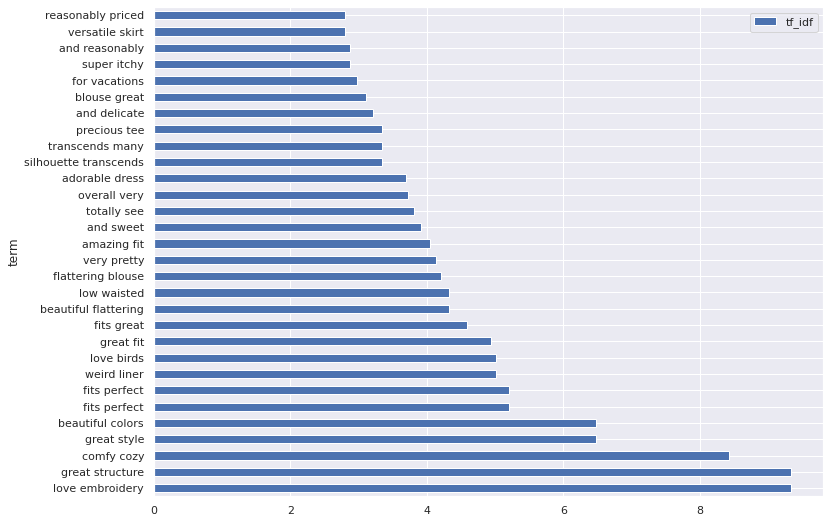

In [8]:
#plot it:
df_tf_idf.sort_values(by = 'tf_idf', ascending = False).head(30).set_index('term')[['tf_idf']].plot(kind = 'barh', legend = True, figsize = (12, 9));

<footer style="padding:10px;background:#f9f9f9;border-bottom:3px solid #394851">©2021 Teradata. All Rights Reserved</footer>